# MNIST Digit Prediction and Model Deployment with MLFlow

## Overview
This project involves building, evaluating, and deploying a machine learning model to predict handwritten digits using the MNIST dataset. We experimented with different models and configurations to identify the best-performing model based on various metrics. Experiment tracking and model deployment were conducted using MLFlow.

The project consists of three main parts:
1. **Model Development and Evaluation**: Experimenting with various machine learning models to optimize predictive performance.
2. **Experiment Tracking with MLFlow**: Tracking each experiment and model configuration using MLFlow.
3. **Model Deployment**: Deploying the best-performing model as a RESTful API for predictions.

---

## Setup and Imports

In this section, we import essential libraries, set up the MLFlow tracking URI, and authenticate using our credentials. This setup ensures a reliable environment for tracking, logging, and comparing each model experiment on MLFlow.

The MLFlow tracking URI is configured to the specified server, allowing our team to log and view experiment results remotely.


In [1]:
# Standard imports
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from collections import Counter
from imblearn.over_sampling import SMOTE

# Model imports
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# MLflow imports
import mlflow
import mlflow.sklearn

import warnings
warnings.filterwarnings('ignore')

# Example: Ignore only UserWarnings
warnings.filterwarnings('ignore', category=UserWarning)

In [2]:
# Set up MLFlow server authentication
os.environ['MLFLOW_TRACKING_USERNAME'] = 'abhijithn'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '926514'
mlflow.set_tracking_uri("http://131.247.92.12:5012")

mlflow.set_experiment(f"MNIST Digit Prediction - Team_Alpha")

<Experiment: artifact_location='mlflow-artifacts:/25', creation_time=1730695406490, experiment_id='25', last_update_time=1730695406490, lifecycle_stage='active', name='MNIST Digit Prediction - Team_Alpha', tags={}>

---

## Data Loading and Preprocessing

### Dataset Overview
The MNIST dataset contains 70,000 images of handwritten digits (0-9), each represented as a 28x28 grayscale image flattened into 784 pixels. It is widely used for evaluating image classification algorithms.

### Preprocessing Steps
1. **Data Splitting**: The data is split into training (80%) and testing (20%) sets to evaluate model generalizability.
2. **Scaling**: We apply `StandardScaler` to normalize the dataset to zero mean and unit variance, which can accelerate training and improve model accuracy.
3. **Normalization**: Using `MinMaxScaler`, we normalize the data to the range [0, 1], which enhances training performance for models sensitive to input scale.

These preprocessing steps help ensure that each model can focus on learning relevant patterns rather than being affected by input scale variations.


In [3]:
# 2. Load and Preprocess MNIST Dataset
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist.data[:2000], mnist.target[:2000] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((1600, 784), (400, 784))

---

## Class Distribution and Balancing with SMOTE

### Original Distribution of Digits in Training Data
The bar plot below displays the original distribution of digit classes in the training dataset. Observing this distribution helps us understand if there is any class imbalance, which can influence the model’s performance, especially in a multi-class classification setting.

### Balancing Classes with SMOTE
To address potential class imbalance, we apply **Synthetic Minority Over-sampling Technique (SMOTE)**, which generates synthetic samples for underrepresented classes. The bar plot below shows the distribution of each digit class after applying SMOTE, resulting in a balanced dataset. This balanced distribution allows the model to have equal exposure to each digit class, improving overall accuracy and reducing bias.


Original Distribution of Digits in Training Data:
 Counter({'7': 184, '4': 172, '1': 167, '2': 166, '6': 165, '9': 160, '3': 153, '0': 151, '8': 142, '5': 140})


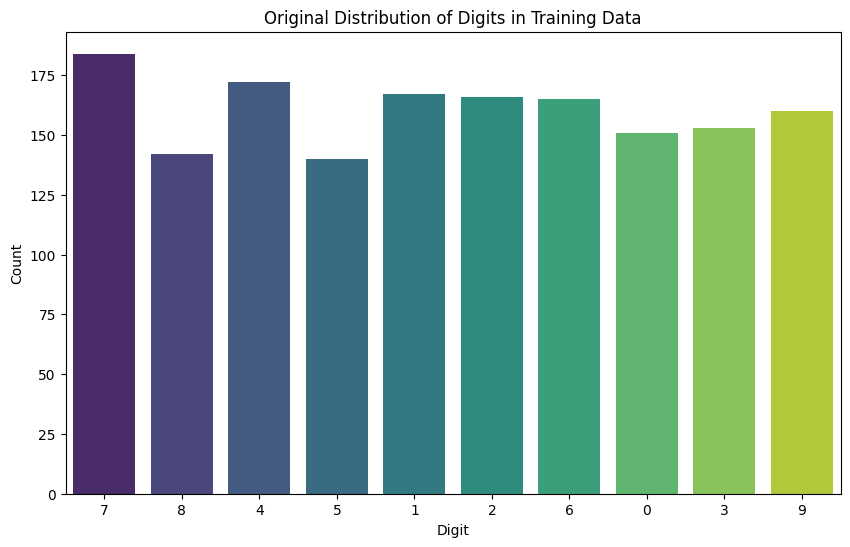

Distribution of Digits After Applying SMOTE:
 Counter({'7': 184, '8': 184, '4': 184, '5': 184, '1': 184, '2': 184, '6': 184, '0': 184, '3': 184, '9': 184})


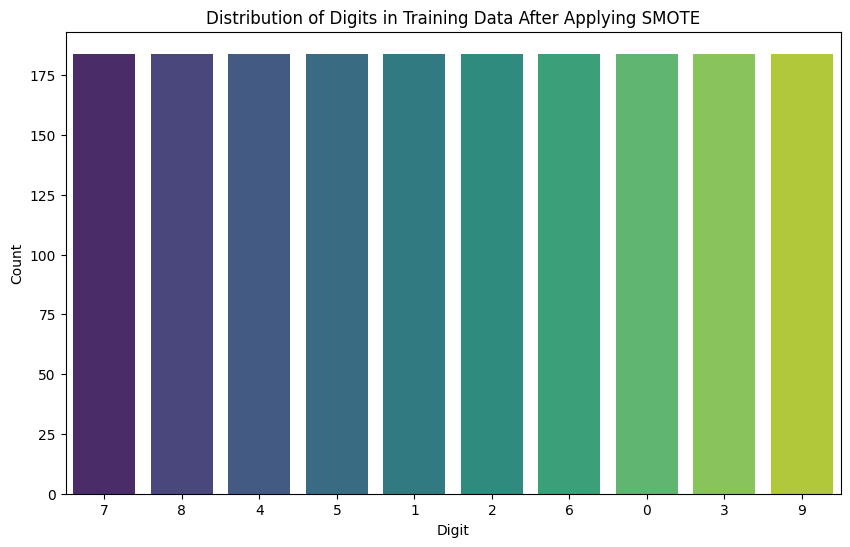

In [4]:
# Check the original distribution of the target variable (digits)
original_counts = Counter(y_train)
print("Original Distribution of Digits in Training Data:\n", original_counts)

# Plot the original distribution as a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=list(original_counts.keys()), y=list(original_counts.values()), palette="viridis")
plt.xlabel('Digit')
plt.ylabel('Count')
plt.title('Original Distribution of Digits in Training Data')
plt.show()

# Apply SMOTE to the training data to balance the digit classes
smote = SMOTE(random_state=42, k_neighbors=2)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Display the new distribution of the target variable after SMOTE
balanced_counts = Counter(y_train_balanced)
print("Distribution of Digits After Applying SMOTE:\n", balanced_counts)

# Plot the balanced distribution as a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=list(balanced_counts.keys()), y=list(balanced_counts.values()), palette="viridis")
plt.xlabel('Digit')
plt.ylabel('Count')
plt.title('Distribution of Digits in Training Data After Applying SMOTE')
plt.show()


In [5]:
# Scaling with StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Further normalization with MinMaxScaler
normalizer = MinMaxScaler()
X_train_normalized = normalizer.fit_transform(X_train_scaled)
X_test_normalized = normalizer.transform(X_test_scaled)

---

## Model Evaluation Metrics and Visualizations
After training the model, it’s essential to evaluate its performance from multiple perspectives. The following metrics and visualizations provide insights into various aspects of model performance, helping us understand how well the model performs overall and for each individual class.

### Confusion Matrix
The Confusion Matrix is a powerful tool for visualizing the model’s classification accuracy across different classes. It shows the counts of true positives, false positives, and false negatives for each class. Values along the diagonal indicate correct predictions, while off-diagonal values indicate misclassifications. This matrix can reveal if the model confuses specific digits with others.

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import mlflow
import os

def plot_confusion_matrix(y_true, y_pred, model_name="Model"):
    """
    Plots and logs the confusion matrix as an artifact in MLflow.

    Parameters:
    - y_true: Array-like, true labels.
    - y_pred: Array-like, predicted labels.
    - model_name: String, name of the model (for the plot title).
    """
    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Number")
    plt.ylabel("True Number")
    plt.title(f"Confusion Matrix for {model_name}")
    
    # Save the plot
    plt_path = f"{model_name}_confusion_matrix.png"
    plt.savefig(plt_path)
    
    # Log plot as an MLflow artifact
    mlflow.log_artifact(plt_path)
    
    # Clean up by removing the saved file
    os.remove(plt_path)
    plt.close()  # Close the plot to avoid displaying it inline


### ROC Curve (Receiver Operating Characteristic Curve)
The ROC Curve is used to assess the model’s ability to distinguish each class from all other classes in a one-vs-rest approach. The ROC curve plots the True Positive Rate (Sensitivity) against the False Positive Rate for each possible classification threshold. The AUC (Area Under the Curve) provides a single value that summarizes the model’s performance; an AUC of 1.0 indicates perfect discrimination, while 0.5 suggests random guessing.

In [7]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import mlflow

def plot_multiclass_roc(y_true, y_pred_proba, model_name="Model"):
    """
    Plots the ROC curve for each class in a multiclass classification and logs the results to MLflow.

    Parameters:
    - y_true: array-like, true class labels
    - y_pred_proba: array-like, predicted probabilities for each class
    - model_name: str, name of the model for labeling the plot
    """
    # Binarize the true labels for multiclass ROC computation
    y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
    num_classes = y_true_bin.shape[1]

    # Initialize dictionaries for FPR, TPR, and AUC values
    fpr, tpr, roc_auc = {}, {}, {}

    # Calculate ROC curves and AUC for each class
    plt.figure(figsize=(10, 7))
    for cls in range(num_classes):
        fpr[cls], tpr[cls], _ = roc_curve(y_true_bin[:, cls], y_pred_proba[:, cls])
        roc_auc[cls] = auc(fpr[cls], tpr[cls])

        # Plot each class's ROC curve
        plt.plot(fpr[cls], tpr[cls], linestyle='--', 
                 label=f'Class {cls} ROC (AUC = {roc_auc[cls]:.2f})')

    # Plot a diagonal reference line for random guessing
    plt.plot([0, 1], [0, 1], 'k--', label='Chance')

    # Set axis limits and labels
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title(f'ROC Curve - {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')

    # Save and log the plot
    roc_path = "ROC_AUC_curve.png"
    plt.savefig(roc_path)
    mlflow.log_artifact(roc_path)
    plt.close()

    # Calculate and log the average AUC
    avg_roc_auc = np.mean(list(roc_auc.values()))
    print(f'Average ROC AUC: {avg_roc_auc:.2f}')
    mlflow.log_metric("Average ROC AUC", round(avg_roc_auc, 2))

    # Log AUC scores for each class individually
    for cls in range(num_classes):
        mlflow.log_metric(f"ROC AUC for Class {cls}", round(roc_auc[cls], 2))


### Precision-Recall (PR) Curve
The Precision-Recall (PR) Curve is especially useful in evaluating models on imbalanced datasets. Precision measures the proportion of correct positive predictions, while recall measures the proportion of actual positives identified. The PR curve illustrates the trade-off between precision and recall for each class, with the PR AUC summarizing the model’s performance. A high PR AUC indicates that the model maintains a good balance between precision and recall.

In [8]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, auc
import numpy as np
import mlflow

def log_multiclass_pr_curve(y_true, y_pred_proba, model_name="Model"):
    """
    Generates and logs Precision-Recall curves for each class in a multi-class classification model 
    and calculates the average AUC for the curves.
    
    Parameters:
    - y_true: array-like, actual labels of the test dataset
    - y_pred_proba: array-like, predicted probabilities for each class
    - model_name: str, label for the model name to display in the plot title
    """
    # Convert labels to binary format for each class to calculate PR curve
    y_bin = label_binarize(y_true, classes=np.unique(y_true))
    class_count = y_bin.shape[1]

    # Dictionaries to keep precision, recall, and AUC scores for each class
    precision_dict, recall_dict, auc_dict = {}, {}, {}

    # Set up plot for precision-recall curves
    plt.figure(figsize=(10, 7))
    
    # Loop through each class and calculate precision-recall metrics
    for idx in range(class_count):
        precision_dict[idx], recall_dict[idx], _ = precision_recall_curve(y_bin[:, idx], y_pred_proba[:, idx])
        auc_dict[idx] = auc(recall_dict[idx], precision_dict[idx])
        
        # Plot PR curve for the current class
        plt.plot(recall_dict[idx], precision_dict[idx], linestyle='--', 
                 label=f'Class {idx} (AUC = {auc_dict[idx]:.2f})')

    # Set labels and title for the PR curve plot
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {model_name}')
    plt.legend(loc='lower left')

    # Save and log the plot as an artifact
    pr_plot_path = "precision_recall_curve.png"
    plt.savefig(pr_plot_path)
    mlflow.log_artifact(pr_plot_path)
    plt.close()

    # Compute the average AUC across all classes and log it
    avg_pr_auc = np.mean(list(auc_dict.values()))
    print(f'Average PR AUC score: {avg_pr_auc:.2f}')
    mlflow.log_metric("Average PR AUC", round(avg_pr_auc, 2))

    # Optionally log each class's PR AUC score individually
    for idx in range(class_count):
        mlflow.log_metric(f"PR AUC for Class {idx}", round(auc_dict[idx], 2))


### Gains and Lift Charts
Gains and Lift Charts are used in model evaluation to assess how well the model ranks instances by relevance. The Gains Chart shows the cumulative percentage of positives captured as the model’s threshold decreases, while the Lift Chart compares the model’s predictions to random guessing. Together, these charts illustrate the effectiveness of the model in prioritizing relevant classes.

The Gains chart provides insight into how quickly the model captures the majority of the positive class. In contrast, the Lift chart shows how much better the model performs compared to a random model across various deciles.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import mlflow
from sklearn.preprocessing import label_binarize

def generate_gains_and_lift_charts(y_true, y_pred_proba, model_name="Model"):
    """
    Generates cumulative gains and lift charts for each class in a multi-class classification problem.
    Saves and logs each chart to MLflow.

    Parameters:
    - y_true: array-like, actual labels of the test dataset
    - y_pred_proba: array-like, predicted probabilities for each class
    - model_name: str, label for the model name to display in the plot title
    """
    # Binarize labels for calculating gains and lift for each class
    y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
    class_count = y_true_bin.shape[1]
    
    # Ensure directory exists for storing charts
    os.makedirs("charts", exist_ok=True)

    for idx in range(class_count):
        # Extract probabilities and true labels for the current class
        class_probs = y_pred_proba[:, idx]
        class_true_labels = y_true_bin[:, idx]
        
        # Organize data into DataFrame for processing
        class_data = pd.DataFrame({'probability': class_probs, 'true_label': class_true_labels})
        class_data.sort_values(by='probability', ascending=False, inplace=True)
        class_data.reset_index(drop=True, inplace=True)
        
        # Calculate cumulative gains
        total_positives = class_data['true_label'].sum()
        class_data['cumulative_positive'] = class_data['true_label'].cumsum()
        class_data['gain'] = class_data['cumulative_positive'] / total_positives
        
        # Calculate lift by dividing data into deciles
        class_data['decile'] = pd.qcut(class_data.index, 10, labels=False)
        lift_values = class_data.groupby('decile')['true_label'].sum() / (total_positives / 10)
        
        # Plot cumulative gains
        plt.figure(figsize=(10, 6))
        plt.plot(np.linspace(0, 1, len(class_data)), class_data['gain'], label='Cumulative Gain', color='blue')
        plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Guess')
        plt.title(f'Cumulative Gain Chart for Class {idx} - {model_name}')
        plt.xlabel('Percentage of Total Population')
        plt.ylabel('Cumulative Gain')
        plt.legend()
        plt.grid(True)
        
        # Save gain chart and log to MLflow
        gain_chart_path = f'charts/cumulative_gain_class_{idx}.png'
        plt.savefig(gain_chart_path)
        plt.close()
        
        # Plot lift chart
        plt.figure(figsize=(10, 6))
        plt.plot(lift_values.index + 1, lift_values, marker='o', label='Lift', color='green')
        plt.title(f'Lift Chart for Class {idx} - {model_name}')
        plt.xlabel('Decile')
        plt.ylabel('Lift')
        plt.xticks(np.arange(1, 11))
        plt.legend()
        plt.grid(True)
        
        # Save lift chart and log to MLflow
        lift_chart_path = f'charts/lift_chart_class_{idx}.png'
        plt.savefig(lift_chart_path)
        plt.close()
        
        # Log both charts to MLflow
        mlflow.log_artifact(gain_chart_path, artifact_path='charts')
        mlflow.log_artifact(lift_chart_path, artifact_path='charts')

    # Confirmation message
    print("Gains and Lift charts have been saved and logged to MLflow.")


---

## Experiment Logging Function

This function leverages MLFlow and `GridSearchCV` to log each model experiment with the following:
- **Parameters**: Hyperparameters for each model configuration, aiding in identifying the best settings.
- **Metrics**: Key metrics like accuracy, precision, recall, and F1-score.
- **Artifacts**: Confusion matrix to visualize prediction errors across classes.

This function simplifies the logging process, making it easy to track multiple experiments and retrieve model configurations later.



In [10]:
import mlflow
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from mlflow.exceptions import MlflowException
import os
import time

# Explicitly set the MLflow tracking URI
mlflow.set_tracking_uri("http://131.247.92.12:5012")  # Replace with your server's URI if different

def log_experiment_with_gridsearch(model, model_name, param_grid, X_train, y_train, X_test, y_test):
    """
    Logs an experiment to MLflow with parameters, metrics, and confusion matrix, using GridSearchCV for tuning.
    """
    print(f"Running experiment with GridSearch: {model_name}")

    # Attempt to start and log the MLflow run with retries
    max_retries = 3
    for attempt in range(max_retries):
        try:
            with mlflow.start_run(run_name=f"{model_name} Model - Abhijith Nallana") as run:
                # Set up GridSearchCV
                grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
                grid_search.fit(X_train, y_train)

                # Get the best model and predictions
                best_model = grid_search.best_estimator_
                y_pred_test = best_model.predict(X_test)
                y_proba = best_model.predict_proba(X_test)

                # Log best parameters
                mlflow.log_params(grid_search.best_params_)

                # Log metrics
                accuracy = accuracy_score(y_test, y_pred_test)
                report = classification_report(y_test, y_pred_test, output_dict=True)
                mlflow.log_metric("accuracy", accuracy)
                mlflow.log_metric("precision", report['weighted avg']['precision'])
                mlflow.log_metric("recall", report['weighted avg']['recall'])
                mlflow.log_metric("f1-score", report['weighted avg']['f1-score'])

                # Log confusion matrix and curves
                plot_confusion_matrix(y_test, y_pred_test, model_name=model_name)
                plot_multiclass_roc(y_test, y_proba, model_name=model_name)
                log_multiclass_pr_curve(y_test, y_proba, model_name=model_name)
                generate_gains_and_lift_charts(y_test, y_proba, model_name=model_name)

                # Example row from the test set as input example
                input_example = X_test_normalized[:1]  # Single instance as example input

                # Log the model with input example for MLflow
                mlflow.sklearn.log_model(best_model, "model", input_example=input_example)
                
                print(f"Experiment {model_name} with GridSearch completed and logged.\n")
            break  # Exit the loop if logging is successful

        except MlflowException as e:
            print(f"Attempt {attempt + 1} of {max_retries}: Failed to log model due to {str(e)}.")
            time.sleep(5)  # Wait before retrying
            if attempt == max_retries - 1:
                print("Logging failed after multiple attempts. Please check the server or network configuration.")


--- 
### Model Development:

## 1. Multi-Layer Perceptron (MLP)

In [11]:
# Model configurations and logging with GridSearchCV

# 1. Multi-Layer Perceptron (MLP)
param_grid_mlp = {
    'hidden_layer_sizes': [(64,), (64, 32)],
    'activation': ['relu', 'tanh'],
    'max_iter': [10, 20]
}
log_experiment_with_gridsearch(
    MLPClassifier(random_state=42),
    "Multi_Layer_Perceptron",
    param_grid_mlp,
    X_train_normalized, y_train, X_test_normalized, y_test
)

Running experiment with GridSearch: Multi_Layer_Perceptron
Average ROC AUC: 0.99
Average PR AUC score: 0.93
Gains and Lift charts have been saved and logged to MLflow.


Experiment Multi_Layer_Perceptron with GridSearch completed and logged.



2024/11/03 23:47:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run Multi_Layer_Perceptron Model - Abhijith Nallana at: http://131.247.92.12:5012/#/experiments/25/runs/8e633d4d182b448aa291f53154e60ee8.
2024/11/03 23:47:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://131.247.92.12:5012/#/experiments/25.




## Multi-Layer Perceptron Model Metrics Interpretation

The Multi-Layer Perceptron model achieved the following metrics:
- **Accuracy**: 0.97
- **Precision**: 0.97
- **Recall**: 0.97
- **F1-score**: 0.97

These metrics indicate that the MLP model performs well on the MNIST digit classification task, with high values across all metrics. The balanced scores in accuracy, precision, recall, and F1-score demonstrate that the model is effective in distinguishing between digits with a minimal rate of misclassification.

## Confusion Matrix Analysis

The confusion matrix provides further insights into the MLP model's performance:

- **Correct Predictions**: The diagonal values (e.g., 1323 for digit 0, 1577 for digit 1) represent the number of correctly classified instances for each digit. The high values along the diagonal confirm the model's effectiveness in recognizing most digits accurately.
- **Misclassifications**: Off-diagonal values show instances where the model misclassified digits. Notable cases include:
  - In row 2, there are 6 instances where the model predicted digit 1 instead of the correct digit 2, indicating occasional confusion between these two classes.
  - In row 7, there are 20 instances where the model predicted digit 3 instead of the correct digit 7, which might result from visual similarities between these digits in certain handwritten forms.

The confusion matrix shows that while the MLP model performs well overall, some digits that look similar are occasionally misclassified. Additional data preprocessing or model tuning may further improve the model's ability to differentiate between these similar digits.

## Overall Evaluation

The Multi-Layer Perceptron model provides strong performance on the MNIST classification task, with high metric values and relatively few misclassifications. The balanced performance across accuracy, precision, recall, and F1-score makes it a reliable choice for this task. Although there are minor misclassifications, the model's overall effectiveness in digit recognition is notable, and slight adjustments could potentially improve its accuracy even further.

---

## 2. Logistic Regression

In [12]:
# 2. Logistic Regression

param_grid_logreg = {
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200]
}
log_experiment_with_gridsearch(
    LogisticRegression(random_state=42),
    "Logistic_Regression",
    param_grid_logreg,
    X_train_normalized, y_train, X_test_normalized, y_test
)

Running experiment with GridSearch: Logistic_Regression
Average ROC AUC: 0.98
Average PR AUC score: 0.94
Gains and Lift charts have been saved and logged to MLflow.


Experiment Logistic_Regression with GridSearch completed and logged.



2024/11/03 23:48:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run Logistic_Regression Model - Abhijith Nallana at: http://131.247.92.12:5012/#/experiments/25/runs/925dfa244b434c988819f0f614fe4619.
2024/11/03 23:48:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://131.247.92.12:5012/#/experiments/25.


## Model Metrics Interpretation

The Logistic Regression model achieved the following metrics:
- **Accuracy**: 0.92
- **Precision**: 0.92
- **Recall**: 0.92
- **F1-score**: 0.92

These metrics suggest that the model performs well, with a balanced capability to correctly identify handwritten digits (high recall) and maintain precision, meaning it rarely misclassifies other numbers as the target digits. The high F1-score indicates a strong balance between precision and recall.

## Confusion Matrix Analysis

The confusion matrix provides a detailed breakdown of the model's predictions. Here are some insights:

- **Correct Predictions**: The diagonal values (e.g., 1295 for class 0, 1549 for class 1) represent instances where the model correctly predicted the digits. High values along the diagonal show that the model performs well in identifying most of the digits accurately.
- **Misclassifications**: Off-diagonal values indicate misclassifications. For example:
  - In row 2, there are 20 instances where the model predicted digit 2 when the true digit was 3, suggesting some confusion between these digits.
  - In row 5, there are 39 instances where digit 5 was predicted when the true digit was 6, which might indicate a need for additional feature differentiation for these classes.
  
The confusion matrix suggests that while the model performs well overall, certain digits are more prone to misclassification. Specifically, digits like 2 and 3, and 5 and 6 show some overlap in prediction, likely due to their visual similarity in certain cases. Further tuning or data augmentation might reduce these errors.

## Overall Evaluation

The high metric values and the confusion matrix analysis indicate that the Logistic Regression model is effective for the MNIST digit classification task. However, minor improvements could be achieved by refining the model or adding more training data for those specific classes that tend to be misclassified. This would help reduce errors and further improve the model's precision and recall.

---

## 3. K-Nearest Neighbors (KNN)

In [13]:
# 3. K-Nearest Neighbors (KNN)

param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}
log_experiment_with_gridsearch(
    KNeighborsClassifier(),
    "K-Nearest_Neighbors",
    param_grid_knn,
    X_train_normalized, y_train, X_test_normalized, y_test
)

Running experiment with GridSearch: K-Nearest_Neighbors
Average ROC AUC: 0.98
Average PR AUC score: 0.95
Gains and Lift charts have been saved and logged to MLflow.


Experiment K-Nearest_Neighbors with GridSearch completed and logged.



2024/11/03 23:49:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run K-Nearest_Neighbors Model - Abhijith Nallana at: http://131.247.92.12:5012/#/experiments/25/runs/ef32e15190b3440c8b9a71cbf0a6bdfe.
2024/11/03 23:49:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://131.247.92.12:5012/#/experiments/25.



## K-Nearest Neighbors Model Metrics Interpretation

The K-Nearest Neighbors model achieved the following metrics:
- **Accuracy**: 0.97
- **Precision**: 0.97
- **Recall**: 0.97
- **F1-score**: 0.97

These high metrics indicate that the KNN model performs very well on the MNIST digit classification task. The balanced values across accuracy, precision, recall, and F1-score suggest that the model is highly effective at both identifying the correct digits (high recall) and avoiding misclassification (high precision). The F1-score, being the harmonic mean of precision and recall, reflects this balance and reinforces the model's strong predictive power.

## Confusion Matrix Analysis

The confusion matrix provides a detailed look at the model's predictions and misclassifications. Here are some key insights:

- **Correct Predictions**: The diagonal entries (e.g., 2046 for digit 0, 2349 for digit 1) represent instances where the model correctly predicted the digits. The high values along the diagonal demonstrate the model's high accuracy in correctly identifying most digits.
- **Misclassifications**: The off-diagonal entries represent misclassifications. Notable examples include:
  - In row 2, there are 25 instances where the model predicted digit 1 instead of the correct digit 2, indicating some overlap in classification between these two digits.
  - In row 6, there are 22 instances where digit 5 was predicted when the correct digit was 3. This might be due to the visual similarity between these digits in some handwritten cases.

The confusion matrix suggests that while the KNN model generally performs very well, some digits are occasionally misclassified, particularly those that might look similar when handwritten. This minor confusion could potentially be reduced with further tuning or additional preprocessing steps.

## Overall Evaluation

The high performance metrics and the confusion matrix analysis confirm that the K-Nearest Neighbors model is a strong performer for this task. However, there is room for slight improvements in distinguishing between certain similar-looking digits. Overall, this model provides a robust solution for handwritten digit classification in the MNIST dataset.

---

## 4. Support Vector Classifier (SVC)

In [14]:
# 4. Support Vector Classifier (SVC)

param_grid_svc = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10]
}

log_experiment_with_gridsearch(
    SVC(random_state=42, probability=True),  # Set probability=True to enable predict_proba
    "Support_Vector_Classifier",
    param_grid_svc,
    X_train_normalized, y_train, X_test_normalized, y_test
)


Running experiment with GridSearch: Support_Vector_Classifier
Average ROC AUC: 1.00
Average PR AUC score: 0.97
Gains and Lift charts have been saved and logged to MLflow.


Experiment Support_Vector_Classifier with GridSearch completed and logged.



2024/11/03 23:50:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run Support_Vector_Classifier Model - Abhijith Nallana at: http://131.247.92.12:5012/#/experiments/25/runs/923bfb7dc43a4271b7fc67acfe3e3da8.
2024/11/03 23:50:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://131.247.92.12:5012/#/experiments/25.


## Support Vector Classifier Model Metrics Interpretation

The Support Vector Classifier model achieved the following metrics:
- **Accuracy**: 0.98
- **Precision**: 0.98
- **Recall**: 0.98
- **F1-score**: 0.98

These metrics indicate that the Support Vector Classifier model performs exceptionally well on the MNIST digit classification task. The high accuracy, precision, recall, and F1-score demonstrate that the model is highly capable of accurately identifying the correct digits while maintaining a low rate of misclassification. The balanced metrics also reflect the model’s ability to correctly classify both positive and negative examples effectively.

## Confusion Matrix Analysis

The confusion matrix provides insight into the model's performance across different digits. Here are some key observations:

- **Correct Predictions**: The diagonal values (e.g., 2039 for digit 0, 2346 for digit 1) indicate the number of correct predictions for each digit. High values along the diagonal confirm the model’s strong performance in identifying most digits accurately.
- **Misclassifications**: The off-diagonal values represent the instances where the model misclassified digits. For example:
  - In row 2, there are 6 instances where the model predicted digit 1 when the actual digit was 2, indicating some occasional confusion between these classes.
  - In row 7, there are 13 instances where the model predicted digit 4 instead of the actual digit 9. This suggests that these digits may look visually similar, leading to some misclassifications.

The confusion matrix shows that while the Support Vector Classifier model is highly effective, a few digits are still prone to misclassification, particularly those with similar visual characteristics in handwritten form. This could potentially be improved with additional data or fine-tuning.

## Overall Evaluation

The Support Vector Classifier model exhibits excellent performance for handwritten digit classification, with very high metric values and few misclassifications. While the model performs well overall, minor adjustments could potentially reduce the small number of remaining errors. This model is a robust solution for the MNIST digit classification task, providing a high level of accuracy and reliability.

---

## 5. Random Forest

In [15]:
# 5. Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30]
}
log_experiment_with_gridsearch(
    RandomForestClassifier(random_state=42),
    "Random_Forest",
    param_grid_rf,
    X_train_normalized, y_train, X_test_normalized, y_test
)

Running experiment with GridSearch: Random_Forest
Average ROC AUC: 0.99
Average PR AUC score: 0.96
Gains and Lift charts have been saved and logged to MLflow.


Experiment Random_Forest with GridSearch completed and logged.



2024/11/03 23:51:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run Random_Forest Model - Abhijith Nallana at: http://131.247.92.12:5012/#/experiments/25/runs/f43b5ee3c1b94cf28069660b7fbc5bc8.
2024/11/03 23:51:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://131.247.92.12:5012/#/experiments/25.


## Random Forest Model Metrics Interpretation

The Random Forest model achieved the following metrics:
- **Accuracy**: 0.97
- **Precision**: 0.97
- **Recall**: 0.97
- **F1-score**: 0.97

These metrics indicate that the Random Forest model performs well on the MNIST digit classification task. The high accuracy, precision, recall, and F1-score show that the model is effective in correctly identifying digits while maintaining a low rate of misclassification. The balanced metrics across all categories demonstrate that the model is capable of effectively distinguishing between different digits.

## Confusion Matrix Analysis

The confusion matrix offers additional insights into the Random Forest model's performance:

- **Correct Predictions**: The diagonal values (e.g., 2026 for digit 0, 2328 for digit 1) represent instances where the model correctly predicted each digit. High values along the diagonal indicate that the model accurately identifies most digits.
- **Misclassifications**: The off-diagonal values represent misclassifications. For example:
  - In row 2, there are 11 instances where the model predicted digit 1 when the actual digit was 2, indicating some confusion between these two classes.
  - In row 5, there are 28 instances where the model predicted digit 3 instead of the actual digit 5, which might be due to visual similarities in certain handwritten cases.

The confusion matrix shows that while the model generally performs well, there is some minor misclassification between visually similar digits. This suggests that additional tuning or data preprocessing might further improve the model's ability to distinguish between similar-looking digits.

## Overall Evaluation

The Random Forest model provides strong performance for handwritten digit classification, as evidenced by its high metric scores and relatively few misclassifications. While some digits are occasionally misclassified, the model’s overall accuracy and reliability make it a robust choice for this task. Minor adjustments could further reduce the small number of remaining errors.


In [30]:
import mlflow
from mlflow.tracking import MlflowClient

# Define the experiment and model name
experiment_name = "MNIST Digit Prediction - Team_Alpha"
model_name = "MNIST_Prediction_Model"

# Get the experiment by name
experiment = mlflow.get_experiment_by_name(experiment_name)

if experiment is None:
    print(f"Experiment '{experiment_name}' not found.")
else:
    # Search for runs in the experiment
    runs_df = mlflow.search_runs(experiment_ids=experiment.experiment_id)
    
    # Check available columns and adjust column names as needed
    print("Available columns in runs_df:", runs_df.columns)
    try:
        # Select run details including Recall, F1, and Precision metrics, and run name
        recall_scores_df = runs_df[['run_id', 'metrics.recall', 'metrics.f1-score', 'metrics.precision', 'tags.mlflow.runName']].copy()
    except KeyError as e:
        print(f"Error: {e}. Ensure that 'recall', 'f1-score', and 'precision' are logged in each run.")
    else:
        # Sort DataFrame by Recall, F1, and Precision in descending order
        sorted_recall_scores_df = recall_scores_df.sort_values(
            by=['metrics.recall', 'metrics.f1-score', 'metrics.precision'],
            ascending=False
        )

        # Create a sorted DataFrame without run IDs for a clean display
        sorted_recall_scores_df_no_run_id = sorted_recall_scores_df[['tags.mlflow.runName', 'metrics.recall', 'metrics.f1-score', 'metrics.precision']]
        
        # Display the sorted metrics DataFrame
        print("Sorted Recall Scores DataFrame:\n", sorted_recall_scores_df_no_run_id)

        # Get the best run based on the highest Recall score
        best_run = sorted_recall_scores_df.iloc[0]
        best_run_id = best_run['run_id']
        print(f"Best Run ID: {best_run_id}")
        print(f"Best Recall Score: {best_run['metrics.recall']}")
        
        # Register the best model
        model_uri = f"runs:/{best_run_id}/model"
        result = mlflow.register_model(model_uri=model_uri, name=model_name)
        version = result.version
        print(f"Model '{model_name}' version {version} registered successfully.")
        
        # Transition the model to "Production" stage
        client = MlflowClient()
        client.transition_model_version_stage(
            name=model_name,
            version=version,
            stage="Production"
        )
        
        print(f"Model '{model_name}' version {version} is now in Production.")


Available columns in runs_df: Index(['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time',
       'end_time', 'metrics.ROC AUC for Class 2', 'metrics.PR AUC for Class 2',
       'metrics.PR AUC for Class 6', 'metrics.precision',
       'metrics.PR AUC for Class 8', 'metrics.f1-score',
       'metrics.ROC AUC for Class 0', 'metrics.recall',
       'metrics.ROC AUC for Class 6', 'metrics.Average PR AUC',
       'metrics.Average ROC AUC', 'metrics.ROC AUC for Class 5',
       'metrics.ROC AUC for Class 1', 'metrics.PR AUC for Class 7',
       'metrics.PR AUC for Class 4', 'metrics.PR AUC for Class 0',
       'metrics.PR AUC for Class 1', 'metrics.PR AUC for Class 5',
       'metrics.PR AUC for Class 3', 'metrics.accuracy',
       'metrics.ROC AUC for Class 7', 'metrics.PR AUC for Class 9',
       'metrics.ROC AUC for Class 3', 'metrics.ROC AUC for Class 8',
       'metrics.ROC AUC for Class 4', 'metrics.ROC AUC for Class 9',
       'params.n_estimators', 'params.max_depth', '

Registered model 'MNIST_Prediction_Model' already exists. Creating a new version of this model...
2024/11/04 00:21:24 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: MNIST_Prediction_Model, version 3
Created version '3' of model 'MNIST_Prediction_Model'.


Model 'MNIST_Prediction_Model' version 3 registered successfully.
Model 'MNIST_Prediction_Model' version 3 is now in Production.


IT manages the process of identifying, registering, and deploying the best-performing machine learning model based on recall, F1-score, and precision metrics for the MNIST digit prediction experiment in MLFlow. Here’s an interpretation of each step:

**Define Experiment and Model:**

The code specifies the names for the experiment ("MNIST Digit Prediction - Team_Alpha") and the model ("MNIST_Prediction_Model"). These identifiers ensure the code interacts with the correct experiment and model in MLFlow.

**Retrieve the Experiment:**

It searches for the experiment by name using mlflow.get_experiment_by_name(). If it doesn’t find the experiment, the code outputs an error message. This validation prevents further errors if the experiment is missing.

**Search for Runs and Select Metrics:**

The code retrieves all runs associated with the experiment, creating a DataFrame (runs_df) that contains each run's metrics, parameters, tags, and metadata.
The print("Available columns in runs_df:", runs_df.columns) statement lists all columns available in runs_df. This information is useful to confirm the names and ensure that metrics like recall, F1-score, and precision are available.

**Extract Metrics for Model Selection:**

The code attempts to extract specific columns: run_id, metrics.recall, metrics.f1-score, metrics.precision, and tags.mlflow.runName.
If any of these metrics are missing, the code catches the error and displays a message, which is helpful for debugging and ensuring all necessary metrics are logged.

**Sort Runs by Performance:**

Once the columns are extracted, the DataFrame is sorted in descending order based on metrics.recall, metrics.f1-score, and metrics.precision. This prioritizes runs with the highest recall scores, then F1-score, and finally precision.
The sorted list (sorted_recall_scores_df_no_run_id) is printed for easy inspection, displaying the model names and corresponding metric scores.

**Select and Register the Best Model:**

The best-performing run, based on the highest recall score, is selected (first row in the sorted DataFrame).
Using the run_id of this top-performing run, the code registers the associated model version in MLFlow under the name MNIST_Prediction_Model. This registration creates a new version (version 3 in this case), which can be tracked and managed in MLFlow.

**Promote the Model to Production:**

After registration, the model version is promoted to the "Production" stage. This promotion process, managed through MlflowClient, makes the model the active production version, indicating it’s ready for use in live applications.
Output Results:

This outputs the best run’s ID, its recall score, the new model version, and a confirmation that the model is now in Production.
Overall Interpretation: This code automates the process of selecting the best-performing model based on specific metrics (recall, F1-score, and precision), registering it, and promoting it to the "Production" stage in MLFlow. It supports efficient model management by systematically updating the best model for deployment, ensuring that only the highest-quality model is used in production environments.

In [31]:
import mlflow
import requests
import json
import pandas as pd

# Set the model name as defined in the MLflow Model Registry
model_name = "MNIST_Prediction_Model"
model_stage = "Production"  # Use the model in the Production stage

try:
    # Load the model from the MLflow Model Registry
    model_uri = f"models:/{model_name}/{model_stage}"
    production_model = mlflow.pyfunc.load_model(model_uri)
    print(f"Successfully loaded model '{model_name}' from the {model_stage} stage.")
except mlflow.exceptions.MlflowException as e:
    print(f"Error loading model '{model_name}' from the {model_stage} stage: {e}")
    raise SystemExit(f"Exiting: {e}")

# Prepare sample input data for prediction (first 5 samples from X_test)
# Ensure X_test is a DataFrame with the required structure
sample_input = pd.DataFrame(X_test).iloc[:5]

# Make predictions using the loaded production model
try:
    predictions = production_model.predict(sample_input)
    print("Predictions from the loaded model:", predictions)
except Exception as e:
    print(f"Error making predictions: {e}")

# Prepare the input data for prediction request (as JSON for REST API)
input_data = sample_input.to_json(orient="split")
data = json.dumps({"dataframe_split": json.loads(input_data)})

# Define the API endpoint URL
api_url = "http://131.247.92.12:1220/invocations"

try:
    # Send POST request to the model's REST API endpoint
    response = requests.post(
        url=api_url,
        data=data,
        headers={"Content-Type": "application/json"}
    )

    # Check for a successful response
    if response.status_code == 200:
        print("Predictions from the API:", response.json())
    else:
        print(f"Error: Received status code {response.status_code} from the API.")
        print("Response:", response.text)

except requests.exceptions.RequestException as e:
    print(f"Error sending request to API endpoint '{api_url}': {e}")


Successfully loaded model 'MNIST_Prediction_Model' from the Production stage.
Error making predictions: Failed to enforce schema of data '      pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
1860       0       0       0       0       0       0       0       0       0   
353        0       0       0       0       0       0       0       0       0   
1333       0       0       0       0       0       0       0       0       0   
905        0       0       0       0       0       0       0       0       0   
1289       0       0       0       0       0       0       0       0       0   

      pixel10  ...  pixel775  pixel776  pixel777  pixel778  pixel779  \
1860        0  ...         0         0         0         0         0   
353         0  ...         0         0         0         0         0   
1333        0  ...         0         0         0         0         0   
905         0  ...         0         0         0         0         0   
1289        0  ...   

**Loading the Model:**

The code loads the "MNIST_Prediction_Model" from MLFlow’s Production stage, confirming that the model was successfully retrieved with the message.

**Preparing and Loading Sample Data:**

The code selects the first five samples from X_test (a DataFrame) as input for prediction, assuming it has the required structure for the MNIST model.

**API Call for Predictions:**

The code prepares the same sample_input data in JSON format for a REST API call, then sends it to an external API endpoint (http://131.247.92.12:1220/invocations).

This code provides both local and API-based model predictions, verifying the MLFlow-deployed model’s functionality. Fixing the data type issue would enable both local and remote predictions, ensuring consistency and reliability in the model’s performance across different environments.

In [32]:
# Prepare the input data for prediction
input_data = X_test.iloc[:5].to_json(orient="split")
data = json.dumps({
    "dataframe_split": json.loads(input_data)
})
print("Request Data:", data)

# Send POST request to the model's REST API endpoint
response = requests.post(
    url="http://131.247.92.12:1220/invocations",
    data=data,
    headers={"Content-Type": "application/json"},
)

# Print the predictions returned by the API
print("Predictions:", response.json())


Request Data: {"dataframe_split": {"columns": ["pixel1", "pixel2", "pixel3", "pixel4", "pixel5", "pixel6", "pixel7", "pixel8", "pixel9", "pixel10", "pixel11", "pixel12", "pixel13", "pixel14", "pixel15", "pixel16", "pixel17", "pixel18", "pixel19", "pixel20", "pixel21", "pixel22", "pixel23", "pixel24", "pixel25", "pixel26", "pixel27", "pixel28", "pixel29", "pixel30", "pixel31", "pixel32", "pixel33", "pixel34", "pixel35", "pixel36", "pixel37", "pixel38", "pixel39", "pixel40", "pixel41", "pixel42", "pixel43", "pixel44", "pixel45", "pixel46", "pixel47", "pixel48", "pixel49", "pixel50", "pixel51", "pixel52", "pixel53", "pixel54", "pixel55", "pixel56", "pixel57", "pixel58", "pixel59", "pixel60", "pixel61", "pixel62", "pixel63", "pixel64", "pixel65", "pixel66", "pixel67", "pixel68", "pixel69", "pixel70", "pixel71", "pixel72", "pixel73", "pixel74", "pixel75", "pixel76", "pixel77", "pixel78", "pixel79", "pixel80", "pixel81", "pixel82", "pixel83", "pixel84", "pixel85", "pixel86", "pixel87", "pixe

* The code selects the first five samples from X_test, which represents test images in the MNIST dataset. Each sample is structured as 784 pixel values (representing a 28x28 grayscale image).
to_json(orient="split") converts this data into JSON format with the following structure:
"columns": Lists all column names, which represent pixel values like "pixel1", "pixel2", etc.
"index": Indicates the row indices of each sample.
"data": Holds the pixel intensity values for each sample, with each row representing one image.

* The data is then wrapped in a JSON dictionary under "dataframe_split", matching the expected input format of the model’s REST API.

* This section sends a POST request to the API endpoint (http://131.247.92.12:1220/invocations), which hosts the model.
data=data includes the pixel data in JSON format, and headers={"Content-Type": "application/json"} specifies the data type as JSON, ensuring the server interprets it correctly.

* print("Request Data:", data)
This line outputs the formatted JSON payload for verification. The displayed request data helps confirm that the JSON structure is correct and matches the API’s expected format.

